In [1]:
# !pip install pandas
# !pip install matplotlib
# !pip install sklearn
# !pip install seaborn

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import pickle

from sklearn.metrics import *

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

In [2]:
file = "C:\\Users\\SIMGEK\\Desktop\\BOUN\\Term_Project\\ml-100k\\"

genre_data = pd.read_excel(file + "u_genre.xlsx", names = ['name', 'id'])
movie_data_columns = np.append(['movie_id', 'title', 'release_date', 'video_release_date', 'url'], genre_data['name'].values)
movie_data  = pd.read_excel(file + "u_item.xlsx", names = movie_data_columns)
rating_data = pd.read_excel(file + "u_data.xlsx",names=['user_id', 'movie_id', 'rating', 'timestamp'])

### Method - 1

By looking at other users ratings, we find similar users. Than give a score with the users average rating and wwighted average of the similar users.

Performance of the system is calculated with the users rating giving the movies seen and our score.

In [3]:
Mean = rating_data.groupby(by="user_id",as_index=False)['rating'].mean()

Rating_avg = pd.merge(rating_data,Mean,on='user_id')
Rating_avg['adj_rating']=Rating_avg['rating_x']-Rating_avg['rating_y']
Rating_avg.head()

,user_id,movie_id,rating_x,timestamp,rating_y,adj_rating
0,196,242,3,881250949,3.615385,-0.615385
1,196,393,4,881251863,3.615385,0.384615
2,196,381,4,881251728,3.615385,0.384615
3,196,251,3,881251274,3.615385,-0.615385
4,196,655,5,881251793,3.615385,1.384615


In [4]:
Rating_avg['adj_rating'] .describe(i/100 for i in range(0,100, 10))

count    1.000000e+05
mean    -1.367795e-18
std      1.030817e+00
min     -3.724138e+00
0%      -3.724138e+00
10%     -1.417266e+00
20%     -8.344640e-01
30%     -4.919540e-01
40%     -1.647059e-01
50%      1.015625e-01
60%      3.380282e-01
70%      6.062802e-01
80%      9.393939e-01
90%      1.266667e+00
max      3.508046e+00
Name: adj_rating, dtype: float64

In [5]:
user_movie_mat = Rating_avg.pivot(index='user_id', columns='movie_id', values='adj_rating')
user_movie_mat

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.389706,-0.610294,0.389706,-0.610294,-0.610294,1.389706,0.389706,-2.610294,1.389706,-0.610294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.290323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.709677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.125714,0.125714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.734694,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,-1.457944,NaN,NaN,0.542056,1.542056,-0.457944,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,0.954545,NaN,NaN,NaN,NaN,NaN,-0.045455,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
## Impute NaN values with Movie rating average
user_movie_mat_upd = user_movie_mat.apply(lambda x: x.fillna(x.mean()),axis=0)
user_movie_mat_upd

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.389706,-0.610294,0.389706,-0.610294,-0.610294,1.389706,0.389706,-2.610294,1.389706,-0.610294,...,-1.147059,-0.137056,-0.45933,-1.45933,-0.211982,-2.121495,-0.121495,-1.121495,0.019337,-0.365931
2,0.290323,-0.253455,-0.406476,-0.029170,-0.206708,0.099592,0.241369,0.370904,0.316282,-1.709677,...,-1.147059,-0.137056,-0.45933,-1.45933,-0.211982,-2.121495,-0.121495,-1.121495,0.019337,-0.365931
3,0.299264,-0.253455,-0.406476,-0.029170,-0.206708,0.099592,0.241369,0.370904,0.316282,0.251461,...,-1.147059,-0.137056,-0.45933,-1.45933,-0.211982,-2.121495,-0.121495,-1.121495,0.019337,-0.365931
4,0.299264,-0.253455,-0.406476,-0.029170,-0.206708,0.099592,0.241369,0.370904,0.316282,0.251461,...,-1.147059,-0.137056,-0.45933,-1.45933,-0.211982,-2.121495,-0.121495,-1.121495,0.019337,-0.365931
5,1.125714,0.125714,-0.406476,-0.029170,-0.206708,0.099592,0.241369,0.370904,0.316282,0.251461,...,-1.147059,-0.137056,-0.45933,-1.45933,-0.211982,-2.121495,-0.121495,-1.121495,0.019337,-0.365931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.299264,-0.253455,-0.406476,-0.029170,-0.206708,0.099592,0.241369,0.370904,0.734694,0.251461,...,-1.147059,-0.137056,-0.45933,-1.45933,-0.211982,-2.121495,-0.121495,-1.121495,0.019337,-0.365931
940,0.299264,-0.253455,-0.406476,-1.457944,-0.206708,0.099592,0.542056,1.542056,-0.457944,0.251461,...,-1.147059,-0.137056,-0.45933,-1.45933,-0.211982,-2.121495,-0.121495,-1.121495,0.019337,-0.365931
941,0.954545,-0.253455,-0.406476,-0.029170,-0.206708,0.099592,-0.045455,0.370904,0.316282,0.251461,...,-1.147059,-0.137056,-0.45933,-1.45933,-0.211982,-2.121495,-0.121495,-1.121495,0.019337,-0.365931


In [7]:
# Calculate user similarities
b = cosine_similarity(user_movie_mat_upd)
np.fill_diagonal(b, 0 )

similarity_with_user = pd.DataFrame(b,index=user_movie_mat_upd.index)
similarity_with_user.columns=user_movie_mat_upd.index
similarity_with_user.head()

Rating_avg = Rating_avg.astype({"movie_id": str})

In [8]:
similarity_with_user

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.843356,0.826035,0.857827,0.764312,0.779988,0.713977,0.853533,0.855259,0.816118,...,0.780533,0.837320,0.818577,0.835780,0.794697,0.851909,0.817304,0.859819,0.831436,0.745902
2,0.843356,0.000000,0.927383,0.956761,0.843712,0.872662,0.804099,0.941021,0.956912,0.933291,...,0.884964,0.946499,0.906733,0.951505,0.885671,0.952297,0.909712,0.961835,0.947336,0.857147
3,0.826035,0.927383,0.000000,0.939980,0.827250,0.852937,0.779676,0.923743,0.939207,0.917426,...,0.867559,0.930667,0.889823,0.926949,0.868076,0.934073,0.892905,0.946320,0.924428,0.839377
4,0.857827,0.956761,0.939980,0.000000,0.855949,0.879266,0.801800,0.959257,0.974333,0.946940,...,0.898505,0.964633,0.919858,0.953728,0.900577,0.967555,0.939123,0.982320,0.963425,0.868326
5,0.764312,0.843712,0.827250,0.855949,0.000000,0.768636,0.706424,0.844057,0.854108,0.829360,...,0.791333,0.837326,0.806724,0.840056,0.797082,0.851854,0.811623,0.858221,0.843267,0.771807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.851909,0.952297,0.934073,0.967555,0.851854,0.869683,0.799894,0.949623,0.967211,0.940556,...,0.892357,0.959467,0.916603,0.946732,0.898234,0.000000,0.923148,0.970689,0.952187,0.863511
940,0.817304,0.909712,0.892905,0.939123,0.811623,0.833814,0.762568,0.909567,0.929998,0.909082,...,0.850799,0.925015,0.868994,0.907754,0.854885,0.923148,0.000000,0.935479,0.914600,0.833907
941,0.859819,0.961835,0.946320,0.982320,0.858221,0.886511,0.812112,0.959258,0.979256,0.952376,...,0.900604,0.967857,0.925568,0.962771,0.894868,0.970689,0.935479,0.000000,0.963476,0.872573


In [9]:
## Find the most similar 30 users
order = np.argsort(similarity_with_user.values, axis=1)[:, :30]
sim_users_30 = similarity_with_user.apply(lambda x: pd.Series(x.sort_values(ascending=False)
       .iloc[:30].index, index=['Top{}'.format(i) for i in range(1, 30+1)]), axis=1)

## Get the movies seen by user    
Movie_seen_by_user = user_movie_mat.columns[user_movie_mat[user_movie_mat.index == 3].notna().any()].tolist()

## Simgek added 20/06/2020
## Get the movies not seen by user    
Movie_not_seen_by_user = user_movie_mat.columns[user_movie_mat[user_movie_mat.index == 3].isna().any()].tolist()
###

## Get movies seen by similar users
a = sim_users_30[sim_users_30.index==3].values
b = a.squeeze().tolist()

Movie_user = Rating_avg.groupby(by = 'user_id')['movie_id'].apply(lambda x:','.join(x))

d = Movie_user[Movie_user.index.isin(b)]
l = ','.join(d.values)
Movie_seen_by_similar_users = l.split(',')


## Simgek added 20/06/2020
## Get movies that have not seen by user yet.
#     We first tried to recommend the movies that are not seen by the user, but in order to measure the performance
#     of the system, we changed this part and just used the movies that are seen by user.
#     Movies_under_consideration = list(set(Movie_seen_by_similar_users)-set(list(map(str, Movie_seen_by_user))))

Movies_under_consideration = list(set(Movie_seen_by_similar_users)-set(list(map(str, Movie_not_seen_by_user))))
Movies_under_consideration = list(map(int, Movies_under_consideration))

## Calculate the predicted score of user to movies that have not seen yet by using similar users ratings and similarity
## score (cosine) as weight.

## predicted score s(u,i) = Avg user score + Sum((Similar user's score - Avg score of similar users)*Users similarity rate)
##                                        / Sum(Users similarity rate)

score = []
for item in Movies_under_consideration:

    ## Find the users that watches movies under consideration.
    c = user_movie_mat_upd.loc[:,item]
    d = c[c.index.isin(b)]
    f = d[d.notnull()]
    index = f.index.values.squeeze().tolist()

    avg_user = Mean.loc[Mean['user_id'] == 3,'rating'].values[0]
    user_ratings = Rating_avg[Rating_avg['user_id'] == 3][['movie_id','rating_x']]

    corr = user_movie_mat_upd.loc[3,index]
    fin = pd.concat([f, corr], axis=1)
    fin.columns = ['adj_score','correlation']
    fin['score']=fin.apply(lambda x:x['adj_score'] * x['correlation'],axis=1)
    sum_score = fin['score'].sum()
    sum_corr = fin['correlation'].sum()
    final_score = avg_user + (sum_score/sum_corr)
    score.append(final_score)

data = pd.DataFrame({'movie_id':Movies_under_consideration,'score':score})

top_recommendations = data.sort_values(by='score',ascending=False).head(10)
Movie_Name = top_recommendations.merge(movie_data, how='inner', on='movie_id')

In [10]:
def make_recommendation(user, n):
    
    ## Find the most similar 30 users
    order = np.argsort(similarity_with_user.values, axis=1)[:, :30]
    sim_users_30 = similarity_with_user.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[:30].index, index=['Top{}'.format(i) for i in range(1, 30+1)]), axis=1)
    
    ## Get the movies seen by user    
    Movie_seen_by_user = user_movie_mat.columns[user_movie_mat[user_movie_mat.index == user].notna().any()].tolist()
    
    ## Simgek added 20/06/2020
    ## Get the movies not seen by user    
    Movie_not_seen_by_user = user_movie_mat.columns[user_movie_mat[user_movie_mat.index == user].isna().any()].tolist()
    ###
        
    ## Get movies seen by similar users
    a = sim_users_30[sim_users_30.index==user].values
    b = a.squeeze().tolist()
        
    Movie_user = Rating_avg.groupby(by = 'user_id')['movie_id'].apply(lambda x:','.join(x))
    
    d = Movie_user[Movie_user.index.isin(b)]
    l = ','.join(d.values)
    Movie_seen_by_similar_users = l.split(',')
    
    
    ## Simgek added 20/06/2020
    ## Get movies that have not seen by user yet.
#     We first tried to recommend the movies that are not seen by the user, but in order to measure the performance
#     of the system, we changed this part and just used the movies that are seen by user.
#     Movies_under_consideration = list(set(Movie_seen_by_similar_users)-set(list(map(str, Movie_seen_by_user))))

    Movies_under_consideration = list(set(Movie_seen_by_similar_users)-set(list(map(str, Movie_not_seen_by_user))))
    Movies_under_consideration = list(map(int, Movies_under_consideration))
    
    ## Calculate the predicted score of user to movies that have not seen yet by using similar users ratings and similarity
    ## score (cosine) as weight.
    
    ## predicted score s(u,i) = Avg user score + Sum((Similar user's score - Avg score of similar users)*Users similarity rate)
    ##                                        / Sum(Users similarity rate)
    
    score = []
    for item in Movies_under_consideration:
        
        ## Find the users that watches movies under consideration.
        c = user_movie_mat_upd.loc[:,item]
        d = c[c.index.isin(b)]
        f = d[d.notnull()]
        index = f.index.values.squeeze().tolist()
        
        avg_user = Mean.loc[Mean['user_id'] == user,'rating'].values[0]
        user_ratings = Rating_avg[Rating_avg['user_id'] == user][['movie_id','rating_x']]
        
        corr = user_movie_mat_upd.loc[user,index]
        fin = pd.concat([f, corr], axis=1)
        fin.columns = ['adj_score','correlation']
        fin['score']=fin.apply(lambda x:x['adj_score'] * x['correlation'],axis=1)
        sum_score = fin['score'].sum()
        sum_corr = fin['correlation'].sum()
        final_score = avg_user + (sum_score/sum_corr)
        score.append(final_score)
    
    data = pd.DataFrame({'movie_id':Movies_under_consideration,'score':score})
    
    top_recommendations = data.sort_values(by='score',ascending=False).head(n)
    Movie_Name = top_recommendations.merge(movie_data, how='inner', on='movie_id')
    ##Simgek added 20/06/2020
    Movie_Name.movie_id = Movie_Name.movie_id.astype(str)
    Movie_Name = Movie_Name.merge(user_ratings, how='left', on='movie_id')
    result = Movie_Name[['movie_id','title','score','rating_x']]
    result.rename(columns = {'movie_id':'Movie_ID','title':'Movie_Title','score':'Predicted_Rating',
                            'rating_x':'Actual_Rating'}, inplace=True)
    
    result['Abs_Error_Percent'] = ((result['Actual_Rating'] - result['Predicted_Rating']).abs())/result['Actual_Rating']
    MAPE = round(result['Abs_Error_Percent'].sum(),2)
    MAE = round(((result['Actual_Rating'] - result['Predicted_Rating']).abs()).mean(),2)
    
    print('Recommendations for User {}:'.format(user))
    print('Mean Absolute Error of the System:' + str(MAE))
    print('Total Absolute Error Percentage of the System:' + str(MAPE))
    return result
    

In [11]:
make_recommendation(3,10)

Recommendations for User 3:
Mean Absolute Error of the System:1.07
Total Absolute Error Percentage of the System:3.62


C:\Users\SIMGEK\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\SIMGEK\anaconda3\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Movie_ID,Movie_Title,Predicted_Rating,Actual_Rating,Abs_Error_Percent
0,272,Good Will Hunting (1997),3.658111,2,0.829056
1,318,Schindler's List (1993),3.631028,4,0.092243
2,302,L.A. Confidential (1997),3.520503,2,0.760251
3,181,Return of the Jedi (1983),3.254237,4,0.186441
4,258,Contact (1997),3.235903,2,0.617951
5,268,Chasing Amy (1997),3.227211,3,0.075737
6,346,Jackie Brown (1997),3.095316,5,0.380937
7,340,Boogie Nights (1997),3.022294,5,0.395541
8,303,Ulee's Gold (1997),2.957413,3,0.014196
9,344,"Apostle, The (1997)",2.945412,4,0.263647


In [12]:
## This recommendation made with movies that user did not see.
# make_recommendation(3,10)

### Method 2

Find the most rated 10 films and teach models by movies without demographic data.

In [6]:
# Load data 
with open('model_df_new.pickle', 'rb') as handle:
    model_df = pickle.load(handle)

In [10]:
mov_df = model_df[['movie_id','movie_title','ratings_count','ratings_average']]
mov_df.drop_duplicates(keep= "first",inplace=True) 

C:\Users\SIMGEK\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
selected_movies = mov_df.sort_values(by = 'ratings_count',ascending=False).head(10)
print(selected_movies)
movie_list = selected_movies['movie_id'].to_list()

      movie_id                    movie_title  ratings_count  ratings_average
499         50               Star Wars (1977)            583         4.358491
186        258                 Contact (1997)            509         3.803536
50         100                   Fargo (1996)            508         4.155512
53         181      Return of the Jedi (1983)            507         4.007890
100        294               Liar Liar (1997)            485         3.156701
388        286    English Patient, The (1996)            481         3.656965
61         288                  Scream (1996)            478         3.441423
24           1               Toy Story (1995)            452         3.878319
1409       300           Air Force One (1997)            431         3.631090
579        121  Independence Day (ID4) (1996)            429         3.438228


In [29]:
df_1 = model_df[model_df['movie_id'].isin(movie_list)]

## Drop demographic data & unnecessary columns
to_drop = ['timestamp','age','gender','occupation','movie_title','genres','user_rating_avg','user_movie_count']
df_1.drop(to_drop, axis =1, inplace = True)
df_1.shape

C:\Users\SIMGEK\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(4863, 24)

In [31]:
df_1.dtypes

movie_id             int64
user_id              int64
rating               int64
Action               int64
Adventure            int64
Animation            int64
Children's           int64
Comedy               int64
Crime                int64
Documentary          int64
Drama                int64
Fantasy              int64
Film-Noir            int64
Horror               int64
Musical              int64
Mystery              int64
Romance              int64
Sci-Fi               int64
Thriller             int64
War                  int64
Western              int64
movie_age            int64
ratings_average    float64
ratings_count        int64
dtype: object

In [32]:
a = []
b = []
model_perf1 = pd.DataFrame()

for movie in movie_list:
    df_1_upd = df_1[df_1['movie_id'] == movie]
    
##  Split data into Train/Test data
    y = df_1_upd['rating']
    X = df_1_upd.drop(['movie_id','user_id','rating'], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1881)

    # Instantiate model with 100 decision trees
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 1881)
    # Train the model on training data
    rf.fit(X_train, y_train)
        
    importances = list(rf.feature_importances_)
    feature_importances = [(feature, round(importance, 8)) for feature, importance in zip(X_train.columns, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)[:10]
    [print('Variable: {:10} Importance: {}'.format(*pair)) for pair in feature_importances]
    
    
    print('\n')
    print('Performance Measures for movie: ' + str(movie))
    predictions = rf.predict(X_test)

    mae = (abs(predictions - y_test)).mean()
    mape = ((abs(predictions - y_test)) / y_test).mean()
    a.append(mae)
    b.append(mape)

    print('MAE:', round(mae,2))
    print('MAPE:', round(mape,2))
    print('\n')
    

model_perf1['Movie_ID'] = movie_list
model_perf1['MAE'] = a
model_perf1['MAPE'] = b

Variable: Action     Importance: 0.0
Variable: Adventure  Importance: 0.0
Variable: Animation  Importance: 0.0
Variable: Children's Importance: 0.0
Variable: Comedy     Importance: 0.0
Variable: Crime      Importance: 0.0
Variable: Documentary Importance: 0.0
Variable: Drama      Importance: 0.0
Variable: Fantasy    Importance: 0.0
Variable: Film-Noir  Importance: 0.0


Performance Measures for movie: 50
MAE: 0.72
MAPE: 0.2


Variable: Action     Importance: 0.0
Variable: Adventure  Importance: 0.0
Variable: Animation  Importance: 0.0
Variable: Children's Importance: 0.0
Variable: Comedy     Importance: 0.0
Variable: Crime      Importance: 0.0
Variable: Documentary Importance: 0.0
Variable: Drama      Importance: 0.0
Variable: Fantasy    Importance: 0.0
Variable: Film-Noir  Importance: 0.0


Performance Measures for movie: 258
MAE: 0.76
MAPE: 0.24


Variable: Action     Importance: 0.0
Variable: Adventure  Importance: 0.0
Variable: Animation  Importance: 0.0
Variable: Children's Import

In [33]:
## Base regrassor
rf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=1881, verbose=0, warm_start=False)

We built 10 seperate base models with 1000 trees in each model. Criteria for function to measure the quality of a split is mean squared error.
None of the variables found significant.

Let's try to teach merged data.

Variable: ratings_average      Importance: 0.9
Variable: ratings_count        Importance: 0.04
Variable: Comedy               Importance: 0.02
Variable: movie_age            Importance: 0.02
Variable: Action               Importance: 0.0
Variable: Adventure            Importance: 0.0
Variable: Animation            Importance: 0.0
Variable: Children's           Importance: 0.0
Variable: Crime                Importance: 0.0
Variable: Documentary          Importance: 0.0
Variable: Drama                Importance: 0.0
Variable: Fantasy              Importance: 0.0
Variable: Film-Noir            Importance: 0.0
Variable: Horror               Importance: 0.0
Variable: Musical              Importance: 0.0
Variable: Mystery              Importance: 0.0
Variable: Romance              Importance: 0.0
Variable: Sci-Fi               Importance: 0.0
Variable: Thriller             Importance: 0.0
Variable: War                  Importance: 0.0


MAE: 0.81
MAPE: 0.32




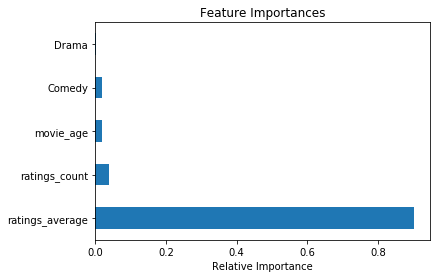

In [78]:
##  Split data into Train/Test data
y = df_1['rating']
X = df_1.drop(['user_id','rating'], axis = 1)
strata = X[['movie_id']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1881, stratify = strata)
X_train = X_train.drop('movie_id', axis = 1)
X_test = X_test.drop('movie_id', axis = 1)

# Instantiate model with 100 decision trees
rf_method2 = RandomForestRegressor(n_estimators = 1000, random_state = 1881)
# Train the model on training data
rf_method2.fit(X_train, y_train)

importances = list(rf_method2.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)[:20]
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

feat_importances = pd.Series(rf_method2.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')

predictions = rf_method2.predict(X_test)

mae = (abs(predictions - y_test)).mean()
mape = ((abs(predictions - y_test)) / y_test).mean()

print('\n')
print('MAE:', round(mae,2))
print('MAPE:', round(mape,2))
print('\n')

import pickle
# Store data
with open('rf_method2.pickle', 'wb') as handle:
    pickle.dump(rf_method2, handle, protocol=pickle.HIGHEST_PROTOCOL)

Predict the all dataset

In [79]:
X_all = model_df[['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
       'movie_age', 'ratings_average', 'ratings_count']]

In [80]:
prediction_method2 = model_df[['user_id','movie_id','rating']]
prediction_method2['predicted_rating'] = rf_method2.predict(X_all)

C:\Users\SIMGEK\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [83]:
prediction_method2.sort_values(by=['user_id','predicted_rating']).head(10)

,user_id,movie_id,rating,predicted_rating
8742,1,259,1,3.242874
17982,1,243,1,3.242874
24890,1,249,4,3.242874
55629,1,261,1,3.242874
60919,1,123,4,3.270530
4961,1,225,2,3.271404
5139,1,120,1,3.271404
5840,1,72,4,3.271404
8831,1,108,5,3.271404
13026,1,85,3,3.271404


In [82]:
prediction_method2[['rating','predicted_rating']].corr()

,rating,predicted_rating
rating,1.000000,0.385265
predicted_rating,0.385265,1.000000


### Method 3

Adding demographic variables to model

In [84]:
df_2 = model_df[model_df['movie_id'].isin(movie_list)]

## Drop unnecessary columns
to_drop = ['timestamp','movie_title','genres','user_rating_avg','user_movie_count']
df_2.drop(to_drop, axis =1, inplace = True)
df_2.shape

C:\Users\SIMGEK\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(4863, 27)

In [85]:
df_2.dtypes

movie_id             int64
user_id              int64
rating               int64
age                  int64
gender              object
occupation          object
Action               int64
Adventure            int64
Animation            int64
Children's           int64
Comedy               int64
Crime                int64
Documentary          int64
Drama                int64
Fantasy              int64
Film-Noir            int64
Horror               int64
Musical              int64
Mystery              int64
Romance              int64
Sci-Fi               int64
Thriller             int64
War                  int64
Western              int64
movie_age            int64
ratings_average    float64
ratings_count        int64
dtype: object

In [86]:
## Encoding Categorical Columns

# creating initial dataframe
cat_df = pd.DataFrame(df_2, columns = ['gender','occupation'])

# generate binary values using get_dummies
dum_df = pd.get_dummies(cat_df, columns = ['gender','occupation'])

# merge with main df bridge_df on key values
df_2 = df_2.join(dum_df)
df_2.drop(['gender','occupation'], axis = 1, inplace = True)
df_2.shape

(4863, 48)

Variable: age        Importance: 0.58
Variable: occupation_other Importance: 0.05
Variable: gender_F   Importance: 0.04
Variable: gender_M   Importance: 0.04
Variable: occupation_writer Importance: 0.04
Variable: occupation_administrator Importance: 0.03
Variable: occupation_educator Importance: 0.02
Variable: occupation_engineer Importance: 0.02
Variable: occupation_healthcare Importance: 0.02
Variable: occupation_librarian Importance: 0.02


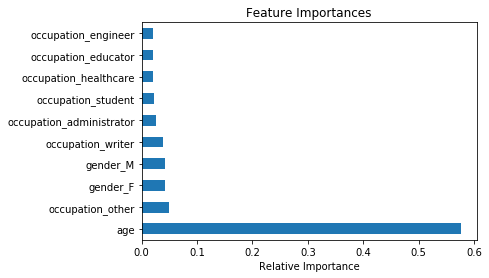

Performance Measures for movie: 50
MAE: 0.79
MAPE: 0.22


Variable: age        Importance: 0.53
Variable: gender_F   Importance: 0.04
Variable: gender_M   Importance: 0.04
Variable: occupation_administrator Importance: 0.04
Variable: occupation_other Importance: 0.04
Variable: occupation_student Importance: 0.04
Variable: occupation_executive Importance: 0.03
Variable: occupation_writer Importance: 0.03
Variable: occupation_educator Importance: 0.02
Variable: occupation_engineer Importance: 0.02


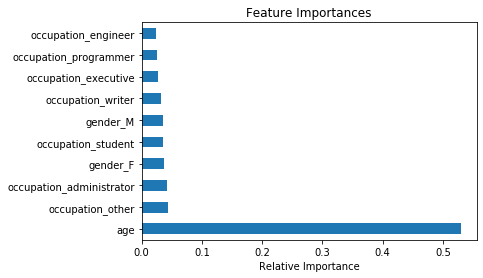

Performance Measures for movie: 258
MAE: 0.94
MAPE: 0.27


Variable: age        Importance: 0.53
Variable: gender_F   Importance: 0.05
Variable: occupation_technician Importance: 0.05
Variable: gender_M   Importance: 0.04
Variable: occupation_engineer Importance: 0.04
Variable: occupation_programmer Importance: 0.04
Variable: occupation_student Importance: 0.04
Variable: occupation_other Importance: 0.03
Variable: occupation_artist Importance: 0.02
Variable: occupation_educator Importance: 0.02


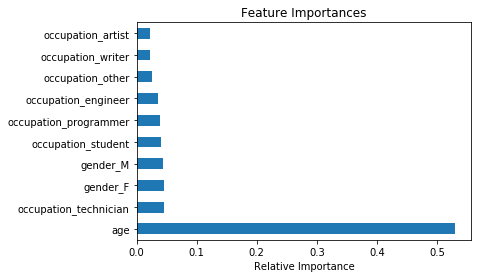

Performance Measures for movie: 100
MAE: 0.87
MAPE: 0.24


Variable: age        Importance: 0.55
Variable: gender_F   Importance: 0.05
Variable: gender_M   Importance: 0.05
Variable: occupation_other Importance: 0.04
Variable: occupation_writer Importance: 0.04
Variable: occupation_administrator Importance: 0.03
Variable: occupation_educator Importance: 0.02
Variable: occupation_engineer Importance: 0.02
Variable: occupation_entertainment Importance: 0.02
Variable: occupation_healthcare Importance: 0.02


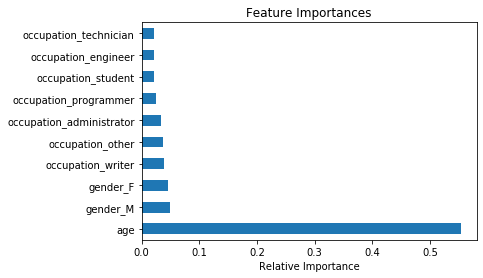

Performance Measures for movie: 181
MAE: 0.71
MAPE: 0.22


Variable: age        Importance: 0.5
Variable: gender_F   Importance: 0.05
Variable: gender_M   Importance: 0.05
Variable: occupation_writer Importance: 0.04
Variable: occupation_administrator Importance: 0.03
Variable: occupation_artist Importance: 0.03
Variable: occupation_educator Importance: 0.03
Variable: occupation_marketing Importance: 0.03
Variable: occupation_other Importance: 0.03
Variable: occupation_student Importance: 0.03


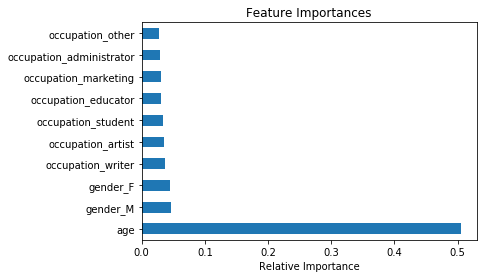

Performance Measures for movie: 294
MAE: 1.03
MAPE: 0.41


Variable: age        Importance: 0.52
Variable: gender_F   Importance: 0.04
Variable: gender_M   Importance: 0.04
Variable: occupation_administrator Importance: 0.03
Variable: occupation_educator Importance: 0.03
Variable: occupation_other Importance: 0.03
Variable: occupation_programmer Importance: 0.03
Variable: occupation_student Importance: 0.03
Variable: occupation_technician Importance: 0.03
Variable: occupation_writer Importance: 0.03


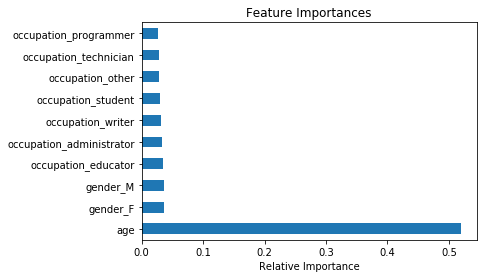

Performance Measures for movie: 286
MAE: 1.1
MAPE: 0.38


Variable: age        Importance: 0.53
Variable: gender_F   Importance: 0.04
Variable: gender_M   Importance: 0.04
Variable: occupation_other Importance: 0.04
Variable: occupation_programmer Importance: 0.04
Variable: occupation_librarian Importance: 0.03
Variable: occupation_student Importance: 0.03
Variable: occupation_technician Importance: 0.03
Variable: occupation_writer Importance: 0.03
Variable: occupation_administrator Importance: 0.02


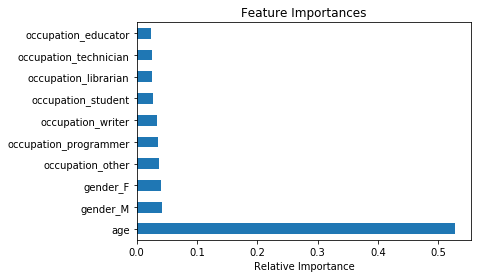

Performance Measures for movie: 288
MAE: 1.05
MAPE: 0.34


Variable: age        Importance: 0.52
Variable: gender_F   Importance: 0.05
Variable: gender_M   Importance: 0.04
Variable: occupation_writer Importance: 0.04
Variable: occupation_artist Importance: 0.03
Variable: occupation_educator Importance: 0.03
Variable: occupation_engineer Importance: 0.03
Variable: occupation_healthcare Importance: 0.03
Variable: occupation_other Importance: 0.03
Variable: occupation_programmer Importance: 0.03


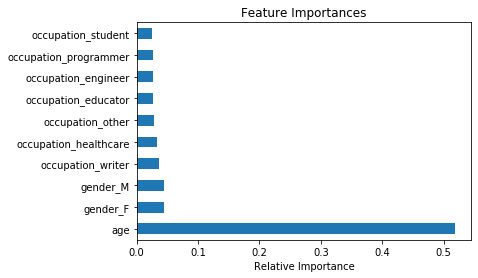

Performance Measures for movie: 1
MAE: 0.68
MAPE: 0.18


Variable: age        Importance: 0.5
Variable: occupation_other Importance: 0.05
Variable: gender_F   Importance: 0.04
Variable: gender_M   Importance: 0.04
Variable: occupation_writer Importance: 0.04
Variable: occupation_educator Importance: 0.03
Variable: occupation_programmer Importance: 0.03
Variable: occupation_student Importance: 0.03
Variable: occupation_administrator Importance: 0.02
Variable: occupation_engineer Importance: 0.02


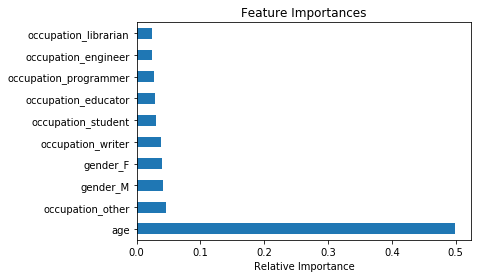

Performance Measures for movie: 300
MAE: 1.0
MAPE: 0.51


Variable: age        Importance: 0.51
Variable: gender_M   Importance: 0.05
Variable: gender_F   Importance: 0.04
Variable: occupation_student Importance: 0.04
Variable: occupation_administrator Importance: 0.03
Variable: occupation_artist Importance: 0.03
Variable: occupation_educator Importance: 0.03
Variable: occupation_engineer Importance: 0.03
Variable: occupation_executive Importance: 0.03
Variable: occupation_other Importance: 0.03


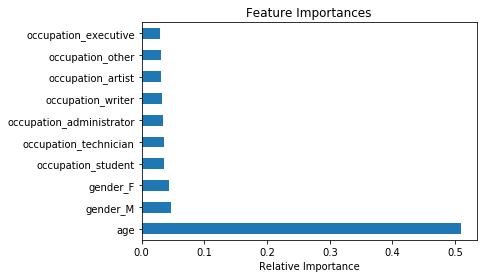

Performance Measures for movie: 121
MAE: 1.01
MAPE: 0.35




In [87]:
a = []
b = []
model_perf2 = pd.DataFrame()

for movie in movie_list:
    df_2_upd = df_2[df_2['movie_id'] == movie]
    
##  Split data into Train/Test data
    y = df_2_upd['rating']
    X = df_2_upd.drop(['movie_id','user_id','rating'], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1881)

    # Instantiate model with 100 decision trees
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 1881)
    # Train the model on training data
    rf.fit(X_train, y_train)
        
    importances = list(rf.feature_importances_)
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)[:10]
    [print('Variable: {:10} Importance: {}'.format(*pair)) for pair in feature_importances]
    
    feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.title('Feature Importances')
    plt.xlabel('Relative Importance')
    plt.show()
    
    print('Performance Measures for movie: ' + str(movie))
    predictions = rf.predict(X_test)

    mae = (abs(predictions - y_test)).mean()
    mape = ((abs(predictions - y_test)) / y_test).mean()
    a.append(mae)
    b.append(mape)

    print('MAE:', round(mae,2))
    print('MAPE:', round(mape,2))
    print('\n')
    
model_perf2['Movie_ID'] = movie_list
model_perf2['MAE'] = a
model_perf2['MAPE'] = b

Age, occupation and gender variables become significant in these models.

### Method 4

When models are built seperately for each movie datasize decrease a lot. Rather than splitting each model, we tried one model with 10 movie id trained together. While seperating train and test tests, in order to ensure the model learn from each movie data, we stratify the dataset with movie_id.

In [122]:
df_3 = model_df[model_df['movie_id'].isin(movie_list)]

## Drop unnecessary columns
to_drop = ['timestamp','movie_title','genres','user_rating_avg','user_movie_count']
df_3.drop(to_drop, axis =1, inplace = True)
df_3.shape

C:\Users\SIMGEK\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(4863, 27)

In [123]:
## Encoding Categorical Columns

# creating initial dataframe
cat_df = pd.DataFrame(df_3, columns = ['gender','occupation'])

# generate binary values using get_dummies
dum_df = pd.get_dummies(cat_df, columns = ['gender','occupation'])

# merge with main df bridge_df on key values
df_3 = df_3.join(dum_df)
df_3.drop(['gender','occupation'], axis = 1, inplace = True)
df_3.shape

(4863, 48)

Variable: age                  Importance: 0.4
Variable: ratings_average      Importance: 0.13
Variable: gender_F             Importance: 0.03
Variable: gender_M             Importance: 0.03
Variable: occupation_other     Importance: 0.03
Variable: occupation_writer    Importance: 0.03
Variable: ratings_count        Importance: 0.02
Variable: occupation_administrator Importance: 0.02
Variable: occupation_artist    Importance: 0.02
Variable: occupation_educator  Importance: 0.02
Variable: occupation_engineer  Importance: 0.02
Variable: occupation_programmer Importance: 0.02
Variable: occupation_student   Importance: 0.02
Variable: occupation_technician Importance: 0.02
Variable: Action               Importance: 0.01
Variable: Comedy               Importance: 0.01
Variable: Drama                Importance: 0.01
Variable: Romance              Importance: 0.01
Variable: Sci-Fi               Importance: 0.01
Variable: Thriller             Importance: 0.01


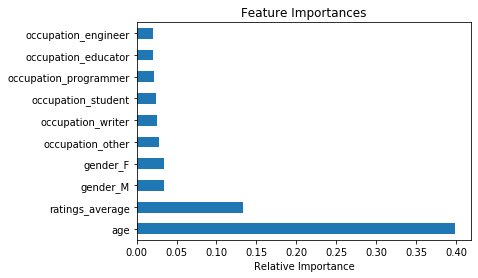



MAE: 0.88
MAPE: 0.33




In [88]:
##  Split data into Train/Test data
y = df_3['rating']
X = df_3.drop(['user_id','rating'], axis = 1)
strata = X[['movie_id']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1881, stratify = strata)
X_train = X_train.drop('movie_id', axis = 1)
X_test = X_test.drop('movie_id', axis = 1)

# Instantiate model with 100 decision trees
rf_method3 = RandomForestRegressor(n_estimators = 1000, random_state = 1881)
# Train the model on training data
rf_method3.fit(X_train, y_train)

importances = list(rf_method3.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)[:20]
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

feat_importances = pd.Series(rf_method3.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.show()

predictions = rf_method3.predict(X_test)

mae = (abs(predictions - y_test)).mean()
mape = ((abs(predictions - y_test)) / y_test).mean()

print('\n')
print('MAE:', round(mae,2))
print('MAPE:', round(mape,2))
print('\n')

import pickle
# Store data
with open('rf_method3.pickle', 'wb') as handle:
    pickle.dump(rf_method3, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [89]:
rf_method3

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=1881, verbose=0, warm_start=False)

Prediction with all dataset

In [118]:
## Drop unnecessary columns
to_drop = ['timestamp','movie_title','genres','user_rating_avg','user_movie_count']
model_df_upd = model_df.drop(to_drop, axis =1)
model_df_upd.shape

# creating initial dataframe
cat_df = pd.DataFrame(model_df_upd, columns = ['gender','occupation'])

# generate binary values using get_dummies
dum_df = pd.get_dummies(cat_df, columns = ['gender','occupation'])

# merge with main df bridge_df on key values
model_df_upd = model_df_upd.join(dum_df)
model_df_upd.drop(['gender','occupation','movie_id', 'user_id', 'rating'], axis = 1, inplace = True)
model_df_upd.shape

(90342, 45)

In [120]:
prediction_method3 = model_df[['user_id','movie_id','rating']]
prediction_method3['predicted_rating'] = rf_method3.predict(model_df_upd)

C:\Users\SIMGEK\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [121]:
prediction_method3[['rating','predicted_rating']].corr()

,rating,predicted_rating
rating,1.000000,0.354094
predicted_rating,0.354094,1.000000


Let's try some hyper parameter tuning with k fold CV

In [63]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100, 250],
    'n_estimators': [50, 100, 500, 1000, 1500, 2000, 5000, 1000]
}

k_fold = 3

# Create a based model
rf = RandomForestRegressor(random_state=1881)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = k_fold, n_jobs = -1, verbose = 2)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 45.3min finished


Best parameters:
{'bootstrap': True, 'max_depth': 50, 'n_estimators': 2000}


Best grid:
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=2000, n_jobs=None, oob_score=False,
                      random_state=1881, verbose=0, warm_start=False)


Variable: age                  Importance: 0.4
Variable: ratings_average      Importance: 0.13
Variable: gender_F             Importance: 0.03
Variable: gender_M             Importance: 0.03
Variable: occupation_other     Importance: 0.03
Variable: occupation_writer    Importance: 0.03
Variable: ratings_count        Importance: 0.02
Variable: occupation_administrator Importance: 0.02
Variable: occupation_artis

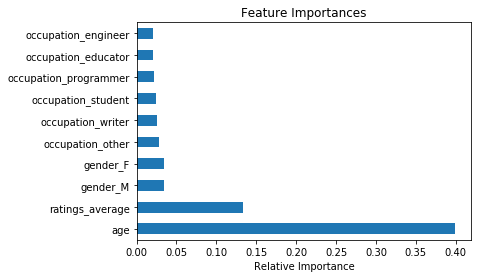





MAE: 0.88
MAPE: 0.33




In [64]:
##  Split data into Train/Test data
y = df_3['rating']
X = df_3.drop(['user_id','rating'], axis = 1)
strata = X[['movie_id']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1881, stratify = strata)
X_train = X_train.drop('movie_id', axis = 1)
X_test = X_test.drop('movie_id', axis = 1)

# Train the model on training data
grid_search.fit(X_train, y_train)

print('Best parameters:')
print(grid_search.best_params_) 
print('\n')
print('Best grid:')
print(grid_search.best_estimator_)

# Train the model on training data with best parameters set
best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)

print('\n')
importances = list(best_grid.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)[:20]
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

feat_importances = pd.Series(best_grid.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.show()

print('\n')
predictions = best_grid.predict(X_test)

mae2 = (abs(predictions - y_test)).mean()
mape2 = ((abs(predictions - y_test)) / y_test).mean()

print('\n')
print('MAE:', round(mae2,2))
print('MAPE:', round(mape2,2))
print('\n')



Variable: age                  Importance: 0.4
Variable: ratings_average      Importance: 0.13
Variable: gender_F             Importance: 0.03
Variable: gender_M             Importance: 0.03
Variable: occupation_other     Importance: 0.03
Variable: occupation_writer    Importance: 0.03
Variable: ratings_count        Importance: 0.02
Variable: occupation_administrator Importance: 0.02
Variable: occupation_artist    Importance: 0.02
Variable: occupation_educator  Importance: 0.02
Variable: occupation_engineer  Importance: 0.02
Variable: occupation_programmer Importance: 0.02
Variable: occupation_student   Importance: 0.02
Variable: occupation_technician Importance: 0.02
Variable: Action               Importance: 0.01
Variable: Comedy               Importance: 0.01
Variable: Drama                Importance: 0.01
Variable: Romance              Importance: 0.01
Variable: Sci-Fi               Importance: 0.01
Variable: Thriller             Importance: 0.01


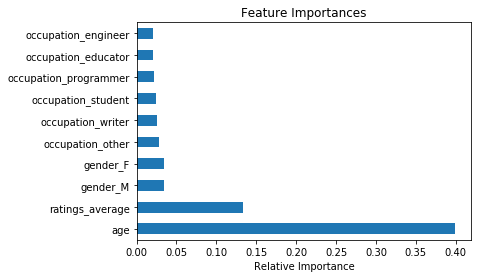





MAE: 0.88
MAPE: 0.33




In [125]:
##  Split data into Train/Test data
y = df_3['rating']
X = df_3.drop(['user_id','rating'], axis = 1)
strata = X[['movie_id']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1881, stratify = strata)
X_train = X_train.drop('movie_id', axis = 1)
X_test = X_test.drop('movie_id', axis = 1)


# Train the model on training data with best parameters set
best_grid = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=2000, n_jobs=None, oob_score=False,
                      random_state=1881, verbose=0, warm_start=False)

best_grid.fit(X_train, y_train)

print('\n')
importances = list(best_grid.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)[:20]
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

feat_importances = pd.Series(best_grid.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.show()

print('\n')
predictions = best_grid.predict(X_test)

mae2 = (abs(predictions - y_test)).mean()
mape2 = ((abs(predictions - y_test)) / y_test).mean()

print('\n')
print('MAE:', round(mae2,2))
print('MAPE:', round(mape2,2))
print('\n')

import pickle
# Store data
with open('best_grid.pickle', 'wb') as handle:
    pickle.dump(best_grid, handle, protocol=pickle.HIGHEST_PROTOCOL)

Prediction with all data

In [126]:
prediction_method4 = model_df[['user_id','movie_id','rating']]
prediction_method4['predicted_rating'] = best_grid.predict(model_df_upd)

C:\Users\SIMGEK\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [127]:
prediction_method4[['rating','predicted_rating']].corr()

,rating,predicted_rating
rating,1.000000,0.354766
predicted_rating,0.354766,1.000000


### Method 5 

Random Forest with full dataset with the hyperparamters found above

In [135]:
## Drop unnecessary columns
to_drop = ['timestamp','movie_title','genres','user_rating_avg','user_movie_count']
model_df_upd = model_df.drop(to_drop, axis =1)
model_df_upd.shape

(90342, 27)

In [136]:
## Encoding Categorical Columns

# creating initial dataframe
cat_df = pd.DataFrame(df_3, columns = ['gender','occupation'])

# generate binary values using get_dummies
dum_df = pd.get_dummies(cat_df, columns = ['gender','occupation'])

# merge with main df bridge_df on key values
model_df_upd = model_df_upd.join(dum_df)
model_df_upd.drop(['gender','occupation'], axis = 1, inplace = True)
model_df_upd.shape

(90342, 25)

Variable: ratings_average      Importance: 0.41
Variable: age                  Importance: 0.32
Variable: ratings_count        Importance: 0.09
Variable: movie_age            Importance: 0.06
Variable: Action               Importance: 0.01
Variable: Adventure            Importance: 0.01
Variable: Children's           Importance: 0.01
Variable: Comedy               Importance: 0.01
Variable: Crime                Importance: 0.01
Variable: Drama                Importance: 0.01
Variable: Romance              Importance: 0.01
Variable: Sci-Fi               Importance: 0.01
Variable: Thriller             Importance: 0.01
Variable: War                  Importance: 0.01
Variable: Animation            Importance: 0.0
Variable: Documentary          Importance: 0.0
Variable: Fantasy              Importance: 0.0
Variable: Film-Noir            Importance: 0.0
Variable: Horror               Importance: 0.0
Variable: Musical              Importance: 0.0


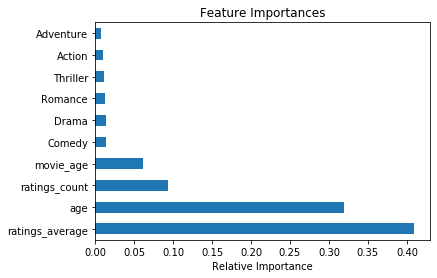



MAE: 0.88
MAPE: 0.34




In [73]:
##  Split data into Train/Test data
y = model_df_upd['rating']
X = model_df_upd.drop(['user_id','rating'], axis = 1)
strata = X[['movie_id']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1881, stratify = strata)
X_train = X_train.drop('movie_id', axis = 1)
X_test = X_test.drop('movie_id', axis = 1)

# Build model with crodd validated parameters above.
rf_all_data = RandomForestRegressor(n_estimators = 2000, max_depth = 50,  random_state = 1881)
# Train the model on training data
rf_all_data.fit(X_train, y_train)

importances = list(rf_all_data.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)[:20]
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

feat_importances = pd.Series(rf_all_data.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.show()

predictions = rf_all_data.predict(X_test)

mae = (abs(predictions - y_test)).mean()
mape = ((abs(predictions - y_test)) / y_test).mean()

print('\n')
print('MAE:', round(mae,2))
print('MAPE:', round(mape,2))
print('\n')

In [74]:
import pickle
# Store data
with open('rf_all_data.pickle', 'wb') as handle:
    pickle.dump(rf_all_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

Prediction of all data

In [137]:
model_df_upd.drop(['movie_id','user_id','rating'], axis = 1, inplace = True)

In [138]:
prediction_method5 = model_df[['user_id','movie_id','rating']]
prediction_method5['predicted_rating'] = rf_all_data.predict(model_df_upd)

C:\Users\SIMGEK\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [139]:
prediction_method5[['rating','predicted_rating']].corr()

,rating,predicted_rating
rating,1.000000,0.623201
predicted_rating,0.623201,1.000000


##### Predict with Method 1

In [105]:
make_recommendation(290,5)

Recommendations for User 290:
Mean Absolute Error of the System:0.8
Total Absolute Error Percentage of the System:1.08


C:\Users\SIMGEK\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\SIMGEK\anaconda3\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Movie_ID,Movie_Title,Predicted_Rating,Actual_Rating,Abs_Error_Percent
0,483,Casablanca (1942),4.142302,5,0.171540
1,318,Schindler's List (1993),4.137004,4,0.034251
2,50,Star Wars (1977),4.080672,5,0.183866
3,357,One Flew Over the Cuckoo's Nest (1975),4.059884,3,0.353295
4,515,"Boot, Das (1981)",4.015158,3,0.338386


In [106]:
make_recommendation(269,5)

Recommendations for User 269:
Mean Absolute Error of the System:0.58
Total Absolute Error Percentage of the System:0.95


C:\Users\SIMGEK\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\SIMGEK\anaconda3\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Movie_ID,Movie_Title,Predicted_Rating,Actual_Rating,Abs_Error_Percent
0,318,Schindler's List (1993),4.152979,4,0.038245
1,515,"Boot, Das (1981)",3.970750,4,0.007313
2,272,Good Will Hunting (1997),3.962281,3,0.320760
3,50,Star Wars (1977),3.929260,3,0.309753
4,302,L.A. Confidential (1997),3.831297,3,0.277099


In [108]:
make_recommendation(153,10)

Recommendations for User 153:
Mean Absolute Error of the System:1.72
Total Absolute Error Percentage of the System:10.49


C:\Users\SIMGEK\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\SIMGEK\anaconda3\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Movie_ID,Movie_Title,Predicted_Rating,Actual_Rating,Abs_Error_Percent
0,64,"Shawshank Redemption, The (1994)",3.782364,5,0.243527
1,127,"Godfather, The (1972)",3.769894,3,0.256631
2,357,One Flew Over the Cuckoo's Nest (1975),3.595166,5,0.280967
3,174,Raiders of the Lost Ark (1981),3.554680,1,2.554680
4,172,"Empire Strikes Back, The (1980)",3.518603,1,2.518603
5,50,Star Wars (1977),3.511230,1,2.511230
6,187,"Godfather: Part II, The (1974)",3.464195,2,0.732097
7,22,Braveheart (1995),3.456536,2,0.728268
8,56,Pulp Fiction (1994),3.357069,5,0.328586
9,258,Contact (1997),3.302339,5,0.339532


As we can see from the three examples above, first method recommends Star Wars in the first 5 for users 290 and 269. WE would expect not to recommend it to user 153 , but it is recommended in the 6th row.

It can be concluded that, this method tend to lower high ratings while increase low ratings.